# 1 - Reconnaissance faciale rapide 
## Contexte et objectif
En 2018, le gouvernement français décide de faire appel à un data scientist pour repérer de potentielles menaces sur des images de vidéosurveillance. L'Etat fournit un jeu de données qui correspond à des portraits des personnes à identifier, au minimum 30 par individu dangereux. Les images font 62 x 47 pixels en niveau de gris.

Votre objectif est de créer un système d'identification ayant une précision minimale de 60% et qui peut fonctionner rapidement. Le challenge est donc de réduire la dimension des images, qui pour chaque observation ont 2914 features : c'est trop pour que l'algorithme fonctionne rapidement.

Commençons par la phase d'importation des packages.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import Isomap
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
%matplotlib inline

- Nous allons maintenant récupérer les données qui nous sont fournies pas le gouvernement.

In [40]:
data = np.genfromtxt('Data_faces1.csv', delimiter=';')
data

# vrai jeu de données non téléchargeable data(2370, 2914) soit 2370 images de 62 x 47 de visages
# vrai target (2370,) soit 2370 lignes de classement des visages de 0 à 33
# toutes les imges sont en noir & blanc
 

array([[-0.13066438,  0.14372328,  0.01824095, ..., -0.03978568,
         0.06862362, -0.006638  ],
       [-0.13048236,  0.05100368,  0.08194965, ..., -0.03373326,
         0.0809923 ,  0.02945542],
       [-0.1634257 ,  0.09083799,  0.05849407, ...,  0.03785266,
         0.13662732,  0.05687651],
       ...,
       [-0.13854785,  0.08956005,  0.10869014, ..., -0.03056408,
         0.0539869 ,  0.07713436],
       [-0.14798048,  0.04013919,  0.05068175, ..., -0.06694285,
         0.10762008,  0.02751997],
       [-0.11219794,  0.09281547,  0.09220099, ..., -0.00384268,
         0.1542632 ,  0.06349568]])

In [41]:
target = np.genfromtxt('Target_face.csv', delimiter=';')
target

array([6., 1., 2., ..., 8., 1., 3.])

In [42]:
data.shape

(2699, 128)

In [43]:
type(data)

numpy.ndarray

In [6]:
target.shape

(2699,)

- Affichons quelques images de notre jeu de données. Il est important de se familiariser avec son jeu de données avant de commencer à travailler dessus.

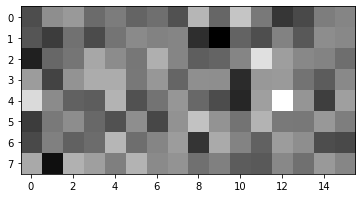

In [7]:
plt.imshow(data[1].reshape((8,16)), cmap='gray')  
# attention reshape(128,) en (8, 16) ou (2,64)  car 8x16=2x64=128  et en en (64,64) car 64x64=4096 !!!

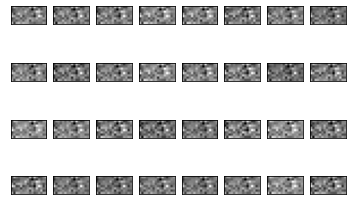

In [8]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(data[i].reshape(8, 16), cmap='gray')

- Nous allons défnir la fonction plot_components. Elle permet de visualiser les éléments d'un jeu de données sur un graphique de projection bidimensionnel.

In [9]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

- Nous allons utiliser Isomap pour identifier les facteurs de variance dans les visages. Le manifold learning est la première étape lorsque l'on récupère un jeu de données. Elle permet d'identifier les facteurs de variance et peut éventuellement nous aider à créer de nouvelles features plus informatives que les features brutes du jeu de données.

C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 10 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\UserPC\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\UserPC\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\UserPC\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\UserPC\anaconda3

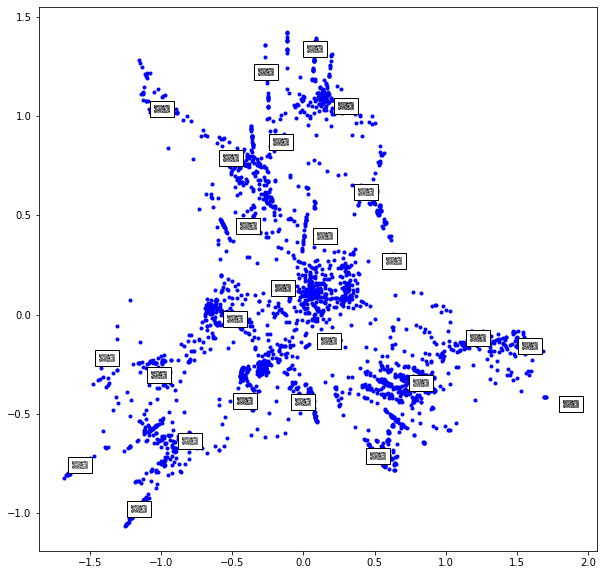

In [10]:
fig, ax = plt.subplots(figsize=(10, 10));

plot_components(data,
                model=Isomap(n_components=2),
                images=data.reshape((-1, 8, 16)),
                cmap = 'gray',
                thumb_frac = .1);

On voit bien que les visages les plus sombres sont à droite du graphe et les visages les plus clairs sont à gauche de l'écran. Dans le même temps l'orientation du visage semble décider de la position sur l'axe vertical : les visages du haut regardent vers la gauche tandis que les visages du bas regardent vers la droite.

Nous allons maintenant réduire la dimension de notre jeu de données en supprimant les pixels qui apportent le moins d'informations. Ainsi le modèle ne s'entrainera pas sur des pixels inutiles.

Avant cela, il est important que l'on mette de côté une partie du jeu de données pour tester le modèle.

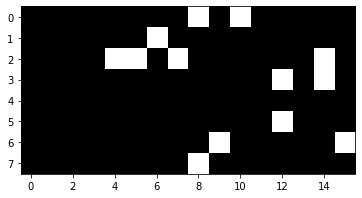

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .2, random_state = 42, shuffle = True)

sel = SelectPercentile(percentile = 90)
sel.fit(X_train, y_train)

X_train_red = sel.transform(X_train)
X_test_red = sel.transform(X_test)

plt.imshow(sel.get_support().reshape(8, 16), cmap = 'gray_r');

- Sans surprise, les pixels qui portent le moins d'information (en blanc sur le masque) sont ceux autour du cou, c'est-à-dire ceux qui ne concernent pas vraiment le visage. Plus étonnant, parmi les pixels du visage, ceux qui portent le moins d'information sont ceux situés au niveau de ce qui semble être la bouche.

On définit la fonction plot_reduced_image pour afficher une image à laquelle on a retiré certains pixels en lui spécifiant la donnée réduite et le sélecteur à utiliser pour récupérer le masque.

In [12]:
def plot_reduced_image(image, selector):
    mask = selector.get_support()
    #toprint = [image[i] if mask[i] == True else 0 for i in range(sum(mask))]
    fullimg = np.array([])
    cnt = 0
    for i in range(8*16):
        if mask[i]:
            fullimg = np.append(fullimg, image[i-cnt])
        else:
            fullimg = np.append(fullimg, 0)
            cnt += 1
    plt.imshow(fullimg.reshape(8,16), cmap = 'gray')

- Affichons la première image du jeu d'entrainement avant et après filtrage des features.

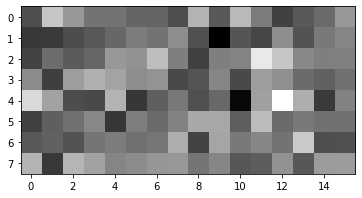

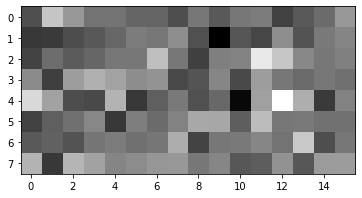

In [13]:
plt.figure()
plt.imshow(X_train[0].reshape(8,16), cmap = 'gray')
plt.show();
plot_reduced_image(X_train_red[0], sel)

Le visage est toujours reconnaissable aisément, comme attendu.

On va maintenant appliquer une PCA sur les images réduites.

In [14]:
pca = PCA(n_components = .9)
X_train_pca = pca.fit_transform(X_train_red)
X_test_pca = pca.transform(X_test_red)

print(pca.n_components_)

9


Nous sommes passés d'un jeu de données de dimension 128 à un jeu de données de dimension 9 : la dimension a été divisée par plus de 14 !

Nous allons afficher ce qu'on appelle les 'eigenfaces'. Ce sont les représentations graphiques des premières composantes principales de la PCA, celles qui portent le plus de variance. Ces formes étranges sont en réalité une base orthogonale dans laquelle tous les visages du jeu de donnés sont décomposés.

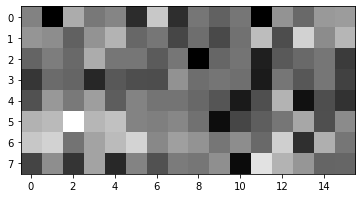

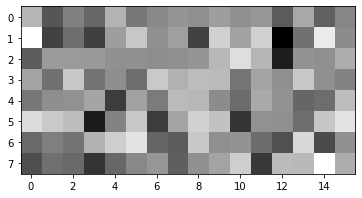

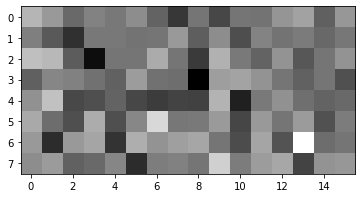

In [15]:
for i in range(3):
    plt.figure()
    plot_reduced_image(pca.components_[i], sel)
    plt.show();

Pour terminer, nous allons comparer les performances d'un classifieur sur le jeu de données original et sur le jeu de données réduit.

In [16]:
svc = SVC(C = 1, kernel = 'linear')
svc.fit(X_train_pca, y_train)
print("Score on reduced data :", svc.score(X_test_pca, y_test))
svc.fit(X_train, y_train)
print("Score on full data :", svc.score(X_test, y_test) )

Score on reduced data : 1.0
Score on full data : 1.0


Les performances en précision sont sensiblement identiques, et mêmes meilleures sur le jeu de données réduit que sur le jeu complet !   

On a donc réussi à diviser la taille du dataset par 30 tout en ayant un effet bénéfique sur les performances du classifieur.  

Nous avons évité l'overfitting du modèle sur le jeu de trop grande dimension. De plus, notre précision est de plus de 70%, comme demandé. Vous l'aurez constaté, si le calcul du score est instantané sur le jeu de données réduit, il prend un temps suffisant pour qu'une application en temps réel ne puisse pas fonctionner sur le jeu de données complet.  

Nous remplissons donc le cahier des charges fourni par l'état : notre traitement de données peut être intégré à un pipeline permettant la détection d'individus menaçant sur des images de videosurveillance.

# 2 - Feature selection 
## 0. Contexte et objectif 
Dans le monde du Machine Learning, bien souvent, les problèmes comportent de très nombreuses valeurs pour chaque observation. Cela peut poser 3 problèmes majeurs : la quantité de stockage nécessaire pour toutes ces données, la vitesse de l’entrainement du modèle trop faible, ou bien encore le phénomène de surajustement (overfitting).

Ces données sont en réalité très souvent corrélées d’une mesure à l’autre, ou bien entre elles. Imaginez un dataset dans lequel une même mesure est exprimée dans deux unités différentes : l’une d’entre elles peut alors être supprimée sans qu’on perde d’information. Identifier ces corrélations permet de réduire drastiquement le nombre de dimensions du jeu de données en y appliquant les transformations appropriées.

En plus de pallier à tous les problèmes précédemment cités, la réduction de dimension permet de visualiser efficacement votre jeu de données avec des représentations graphiques qui permettent de repérer visuellement des structures qui vous aideront à déterminer le modèle adéquat pour résoudre votre problème.

Le fléau de la dimension est un problème classique en Machine Learning. Le fait d’avoir des milliers ou des millions de dimensions pour un nombre limité d’observations implique que les données sont très éparses, ce qui tend à provoquer l’overfitting. Avoir suffisamment d’observations pour atteindre une densité correcte n’est souvent pas envisageable car le nombre d’observations nécessaires est une fonction exponentielle du nombre de prédicteurs. Il devient alors nécessaire de réduire la dimension du dataset, sans perdre les informations importantes.

Il existe différentes méthodes pour réduire la dimension d'un jeu de données, comme la sélection d'un sous-ensemble des features, la combinaison linéaire de features ou encore d'autres méthodes plus avancées (transformées spectrales...).

Nous traiterons dans un premier temps le problème de la feature selection, c'est à dire le choix d'un sous-ensemble de features optimal. Parmi les techniques de feature selection on distingue trois catégories distinctes que nous aborderons toutes : les filter methods, les wrapper methods et les embedded methods.

## 1. Filtering methods 

Pour commencer nous allons importer tous les modules dont nous aurons besoin au cours de cet exercice :

- (a) Exécuter la cellule de code suivante.

In [1]:
# sélection des transformeurs !!!
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Le jeu de données que nous allons utiliser pour cet exercice est un jeu de données qui décrit le marché de l'immobilier à Boston. L'objectif est de savoir quelles features nous permettront de prévoir au mieux à l'aide d'une régression le prix d'une maison en fonction des données qui sont à notre disposition. Les 13 premières colonnes du dataset sont des features qui portent de l'information. Les 10 suivantes sont constituées de nombres aléatoires. Et les 5 dernières sont constantes pour toutes les observations. Nous verrons comment les différentes techniques que nous allons utiliser gèreront ces données.

- (b) Importer le jeu de données real_estate_boston.csv dans un DataFrame nommé df, sans définir de colonne d'index.
- (c) Afficher les 5 premières lignes de df.  
Le fichier real_estate_boston.csv est encodé avec le séparateur ";".

In [50]:
df = pd.read_csv("real_estate_boston.csv", sep = ";")
df.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,...,random7,random8,random9,random10,const1,const2,const3,const4,const5,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,...,0.420765,0.001944,0.165517,0.385965,0.4,1442,0.000045,9.876543,42,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,...,0.300546,0.003952,0.206897,0.798246,0.4,1442,0.000045,9.876543,42,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,...,0.377049,0.001620,0.172414,0.175439,0.4,1442,0.000045,9.876543,42,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,...,0.338798,0.002073,0.296552,0.307018,0.4,1442,0.000045,9.876543,42,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,...,0.300546,0.005183,0.062069,0.254386,0.4,1442,0.000045,9.876543,42,22.9


In [51]:
df.shape

(333, 30)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        333 non-null    int64  
 1   crim      333 non-null    float64
 2   zn        333 non-null    float64
 3   indus     333 non-null    float64
 4   chas      333 non-null    int64  
 5   nox       333 non-null    float64
 6   rm        333 non-null    float64
 7   age       333 non-null    float64
 8   dis       333 non-null    float64
 9   rad       333 non-null    int64  
 10  tax       333 non-null    int64  
 11  ptratio   333 non-null    float64
 12  black     333 non-null    float64
 13  lstat     333 non-null    float64
 14  random1   333 non-null    float64
 15  random2   333 non-null    float64
 16  random3   333 non-null    float64
 17  random4   333 non-null    float64
 18  random5   333 non-null    float64
 19  random6   333 non-null    float64
 20  random7   333 non-null    float6

Lorsque l'on cherche à éliminer des features inutiles, il est souvent intéressant de commencer par une rapide analyse statistique de notre jeu de données.

- (d) A l'aide de la méthode describe, afficher un résumé statistique du jeu de données.

In [53]:
df.iloc[:,0:15].describe()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,random1
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,250.951952,3.360341,10.689189,11.293483,0.060060,0.557144,6.265619,68.226426,3.709934,9.633634,409.279279,18.448048,359.466096,12.515435,0.525826
std,147.859438,7.352272,22.674762,6.998123,0.237956,0.114955,0.703952,28.133344,1.981123,8.742174,170.841988,2.151821,86.584567,7.067781,0.276750
min,1.000000,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,6.000000,1.129600,1.000000,188.000000,12.600000,3.500000,1.730000,0.000000
25%,123.000000,0.078960,0.000000,5.130000,0.000000,0.453000,5.884000,45.400000,2.122400,4.000000,279.000000,17.400000,376.730000,7.180000,0.300000
50%,244.000000,0.261690,0.000000,9.900000,0.000000,0.538000,6.202000,76.700000,3.092300,5.000000,330.000000,19.000000,392.050000,10.970000,0.540000
75%,377.000000,3.678220,12.500000,18.100000,0.000000,0.631000,6.595000,93.800000,5.116700,24.000000,666.000000,20.200000,396.240000,16.420000,0.750000
max,506.000000,73.534100,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,21.200000,396.900000,37.970000,1.000000


In [54]:
df.iloc[:,15:].describe()

,random2,random3,random4,random5,random6,random7,random8,random9,random10,const1,const2,const3,const4,const5,medv
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,3.330000e+02,333.0,3.330000e+02,3.330000e+02,333.0,333.000000
mean,0.486907,4.824324,1.406573,1.774552,0.005301,0.265200,0.003374,0.352532,0.440467,4.000000e-01,1442.0,4.500000e-05,9.876543e+00,42.0,22.768769
std,0.298344,2.880006,0.803280,1.090271,0.002903,0.160539,0.001912,0.199696,0.267048,2.446166e-15,0.0,8.822399e-20,3.024351e-14,0.0,9.173468
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e-01,1442.0,4.500000e-05,9.876543e+00,42.0,5.000000
25%,0.230000,2.200000,0.750000,0.814815,0.003000,0.125683,0.001814,0.186207,0.210526,4.000000e-01,1442.0,4.500000e-05,9.876543e+00,42.0,17.400000
50%,0.480000,4.900000,1.388889,1.740741,0.005300,0.267760,0.003369,0.337931,0.429825,4.000000e-01,1442.0,4.500000e-05,9.876543e+00,42.0,21.600000
75%,0.740000,7.100000,2.111111,2.666667,0.007600,0.398907,0.005183,0.537931,0.692982,4.000000e-01,1442.0,4.500000e-05,9.876543e+00,42.0,25.000000
max,1.000000,10.000000,2.777778,3.703704,0.010000,0.546448,0.006478,0.689655,0.877193,4.000000e-01,1442.0,4.500000e-05,9.876543e+00,42.0,50.000000


La variable cible de ce problème est contenue dans la colonne medv.

- (e) Supprimer la colonne 'ID' du jeu de données.
- (f) Effectuer une séparation jeu d'entrainement/jeu de test en conservant 20% des données dans le jeu de test.

In [55]:
df = df.drop('ID', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(df.drop('medv', 1),df['medv'],test_size = .2)

C:\Users\UserPC\AppData\Local\Temp\ipykernel_7248\2675993653.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('medv', 1),df['medv'],test_size = .2)


### - VarianceThreshold(threshold = 1e-06)
Le principe des méthodes de filtration est d'appliquer un pre-processing au jeu de données en notre possession afin de déterminer à priori le sous-ensemble de features portant le plus d'information. Il existe différentes méthodes et différentes métriques pour mesurer ce critère.

Vous l'avez sûrement constaté en affichant le résumé statistique du jeu de données, les 5 dernières features ont une variance nulle ou presque. Une technique de preprocessing grossière consiste à supprimer les features de variance nulle d'un dataset : elles ne peuvent être d'aucune utilité.

Nous allons utiliser sklearn pour détecter les features de variance nulle.

- (g) Créer un sélecteur VarianceThreshold appelé sel avec un threshold de 1e-6.
- (h) Ajuster ce sélecteur sur le jeu d'entrainement.

In [56]:
# création de l'objet sel = transformeur !!!
sel = VarianceThreshold(threshold = 1e-06)
# entrainement de sel
sel.fit(X_train);

Il est possible de visualiser les features supprimées à l'aide d'un graphique bicolore. La méthode get_support, implémentée sur tous les sélecteurs de variables, renvoie un tableau de booléens qui indique si une feature est conservée ou non. Ce tableau porte le nom de masque.

- (i) Récupérer le masque du sélecteur dans une variable mask.
- (j) Exécuter le code de la cellule pour afficher une représentation des features conservées.

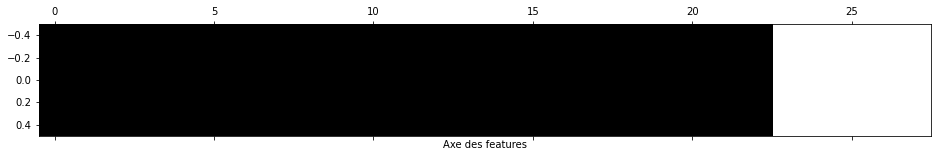

In [57]:
mask = sel.get_support() # Récupére le masque du sélecteur dans une variable mask.
# fig, ax = plt.subplots(figsize=(6, 20)) ne focntionne pas sur matshow
# faire un aspect='auto' pour mise à l'échelle du graph
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
# matshow permet d'afficher un array numpy sous la forme d'une matrice
plt.xlabel('Axe des features');

Supprimer les features de variance inférieure à un certain threshold permet de faire un tri grossier. 

**Attention, cette méthode n'est pas adaptée pour filtrer autre chose que les features de variance nulle**.

Nous allons supprimer les features de variance nulle du jeu de données, afin d'éviter toutes sortes d'erreurs lors des calculs qui vont suivre.

- (k) Sauvegarder le jeu d'entrainement et le jeu de test dans des variables X_train_save et X_test_save. Nous y reviendrons plus tard.
- (l) Supprimer les features de variance nulle des jeux d'entrainement et de test à l'aide de la méthode transform du sélecteur.

In [58]:
X_train_save = X_train
X_test_save = X_test
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

Il existe plusieurs tests statistiques pour classer les variables les unes par rapport aux autres. 

Toutes ces méthodes sont regroupées sous le nom de **Univariate Feature Selection**. 

- Dans le cas d’un problème supervisé, **la dépendance entre la variable cible et les features est mesurée**, 
- tandis que pour un problème de type clustering les **méthodes d'analyse de variance** sont préférées. 

Dans tous les cas de figure, la dépendance entre les features est mesurée au travers de l'information mutuelle.

La méthode pour classer les variables dépend donc essentiellement de la nature des variables et de la nature du problème sous-jacent.

### - SelectKBest et SelectPercentile
Avec sklearn, il est possible de sélectionner k features ou bien un certain pourcentage des features de notre dataset avec les sélecteurs SelectKBest et SelectPercentile.

- (m) Affecter à sel un nouveau sélecteur SelectKBest qui utilise le f-test (score_func = f_regression) pour classer les variables et qui conservera 13 variables.
- (n) Ajuster ce sélecteur sur le jeu d'entrainement.
- (o) Afficher comme précédemment la représentation graphique des features sélectionnées.

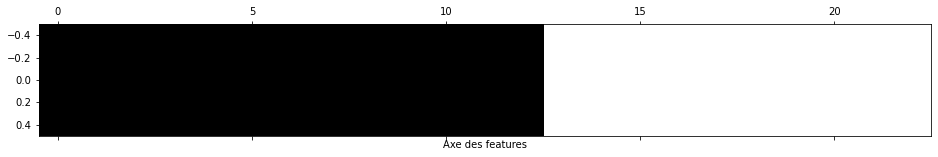

In [59]:
# autre transformeur de feature_selection!!!
sel = SelectKBest(score_func = f_regression, k=13)
sel.fit(X_train, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');

- (p) Répéter la même procédure avec l'information mutuelle ( mutual_info_regression) comme méthode de scoring.
- (q) Comparer les résultats

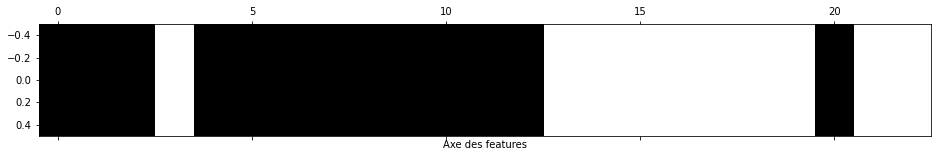

In [60]:
sel = SelectKBest(score_func = mutual_info_regression, k=13)
sel.fit(X_train, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');

Pour mieux comprendre les relations saisies par les différents tests, cet exemple est particulièrement intéressant.  
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html

- Ne pas utiliser un test statistique de régression pour un problème de classification et inversement, les résultats n'auraient pas de sens !

Il est difficile de présenter rapidement l'intégralité des méthodes puisque chacune s'applique à un cas de figure différent. Vous trouverez toutes les infos sur la page de documentation sklearn associée.

Il existe de nombreuses autres techniques pour classer les variables, il est d'ailleurs possible de créer sa propre stratégie avec la fonction GenericUnivariateSelect.

Les méthodes à filtre ont pour avantage d'être particulièrement évolutives car elles requièrent un nombre de calculs limité et fournissent un jeu de features générique, non optimisé pour un algorithme donné. Cela permet de s'attaquer au problème du fléau de la dimension et de l'overfitting, au risque de parfois perdre en précision en comparaison d'autres méthodes que nous verrons par la suite. En effet, les méthodes à filtre ignorent tout à fait les interactions entre les données et l'algorithme sur lequel elles seront appliquées, ce qui peut causer des performances moindres.

## 2. Wrapper methods 

### - RFE
Une autre approche est de considérer l'algorithme de Machine Learning que l'on souhaite utiliser comme une black box. Il est alors possible de tester toutes sortes de combinaisons de features et de considérer le sous-ensemble qui donne les meilleurs résultats selon une métrique choisie. C'est le principe des Wrapper methods, en particulier de la RFE (acronyme pour Recursive Feature Elimination).   

Le principe est simple : on fournit un modèle à l'algorithme RFE, qui est ajusté sur le jeu de données complet. L'importance de chaque feature est estimée et on supprime la ou les features les moins importantes, puis on recommence. Une fois le nombre de features cible atteint, on retourne le jeu de features qui a fourni le meilleur résultat sur le jeu d'entrainement.

- (a) Reprendre les sauvegardes effectuées précédemment comme jeux d'entrainement et de test.
- (b) Affecter à lm une instance de LinearRegression.
- (c) Affecter à rfe une instance de RFE, qui utilise le régresseur linéaire comme estimateur, qui supprime les features une par une et qui en sélectionne finalement 13.
- (d) Ajuster la RFE sur le jeu d'entrainement.
- (e) Afficher la représentation graphique des features sélectionnées.


Un objet RFE est instancié avec les paramètres principaux : estimator, step et n_features_to_select.  
Les méthodes de ce type sont très couteuses en calcul car chaque étape nécessite l'ajustement de nombreux modèles pour en estimer les performances. Ces méthodes sont donc à réserver à des problèmes de taille modeste.



In [61]:
rfe.get_support()

array([False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False])

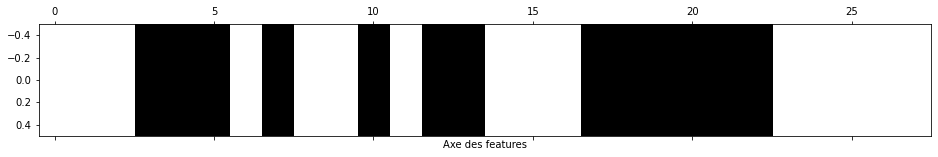

In [62]:
X_test = X_test_save
X_train = X_train_save
lm = LinearRegression()
rfe = RFE(estimator=lm, step=1, n_features_to_select = 13)
rfe.fit(X_train, y_train)

mask = rfe.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');

La **RFE** seule donne des **résultats médiocres** ici car le modèle de régression linéaire est sensible apporte beaucoup d'importance à l'ordre de grandeur des données. Ainsi, les données avec les plus grandes variations "prennent la place" de celles dont les variations sont plus faibles (nous parlons ici de variations absolues).

### - StandardScaler 
Pour pallier à ce problème, nous allons donc appliquer une étape de standardisation des données.

- (f) Créer un objet StandardScaler.
- (g) L'ajuster sur les données d'entrainement.
- (h) Transformer les données d'entrainement et de test avec le StandardScaler.

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- (i) Ajuster la RFE sur le nouveau jeu d'entrainement.
- (j) Afficher la représentation graphique des features sélectionnées.

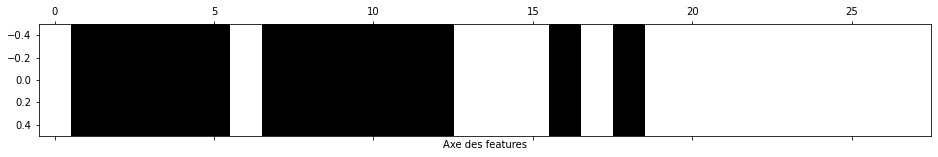

In [64]:
rfe = RFE(estimator=lm, step=1, n_features_to_select = 13)
rfe.fit(X_train, y_train)

mask = rfe.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');
plt.show();

L'objet RFE dispose d'un attribut ranking_. Il permet de savoir dans quel ordre les features ont été éliminées au fur et à mesure des itérations de l'algorithme.

- (k) De la même manière que nous représentions le masque des features sauvegardées, représenter le rang des features éliminées.

**A l'inverse de la représentation précédent**, les features sélectionnées seront représentées par des cases blanches. Plus une case est sombre plus elle a été éliminée tôt dans le processus.

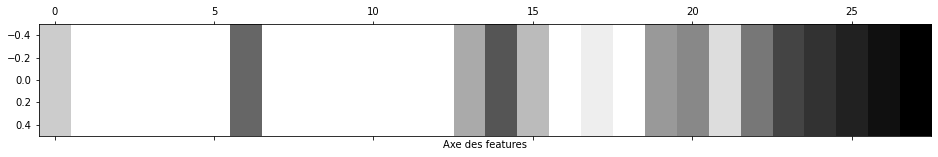

In [65]:
ranking = rfe.ranking_
plt.matshow(ranking.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');
plt.show();

La RFE utilise toujours le même jeu d'entrainement et le même jeu de test. Le fait d'utiliser le même jeu de test pour mesurer les performances de l'algorithme peut conduire à un phénomène d'**overfitting**.

### - RFECV
Pour échapper à cela, il faut intégrer la RFE au sein d'une boucle de cross validation. Il existe une fonction RFECV qui implémente cette méthode dans sklearn. Elle permet également de choisir automatique du nombre de features à conserver selon le meilleur score moyen en cross validation.

- (l) Créer une instance de RFECVappelé rfecv qui prend en paramètre le régresseur précédemment créé, et l'objet crossval fourni dans la cellule.
- (m) Ajuster le modèle sur le jeu d'entrainement.
- (n) Afficher la représentation graphique des features sélectionnées.

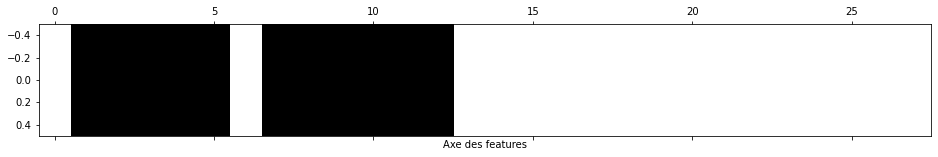

In [66]:
crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=lm, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

mask = rfecv.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');
plt.show();

L'objet RFECV possède deux attributs intéressants pour l'interprétation du résultat.

L'attribut **nfeatures** est un entier qui représente le nombre de features conservées par l'algorithme.

L'attribut **grid_scores_** contient les scores moyens en cross validation de l'estimateur pour les itérations successives.

- (o) Tracer la courbe du score moyen en cross validation en fonction du nombre de features sélectionnées.
- (p) Afficher le nombre de features retenues.

Nombre de features retenus : 11


C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


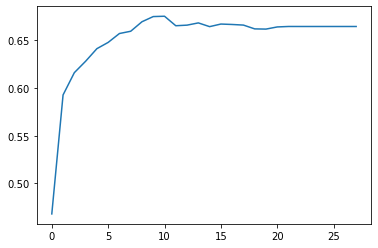

In [67]:
plt.plot(rfecv.grid_scores_.mean(axis=1));
# ou bien cv_results_ si grid_score depreciate
# plt.plot(rfecv.cv_results_);
print("Nombre de features retenus :", rfecv.n_features_)


# 3 - Embedded methods 
Les wrapper methods fournissent de bons résultats mais sont coûteuses en termes de calcul puisqu'il faut ajuster un grand nombre de modèles afin d'en estimer les performances.  

Un compromis existe entre les filter methods et les wrapper methods , ce sont les embedded methods. Ces méthodes exploitent les algorithmes qui se basent sur une régularisation L1, comme **LASSO** pour la régression, ou les SVM pour la classification.  

Sans rentrer dans les détails de ces algorithmes, l'idée est qu'un paramètre de régularisation, noté  λ  ou  α  permet de contracter les valeurs des coefficients de régression associés à chaque variable. Nous allons utiliser les coefficients renvoyés par ces algorithmes, et conserver seulement les features dont les coefficients sont supérieurs à une valeur seuil.  

Usuellement, les features sélectionnées sont celles associées à des coefficients non nuls lorsque LASSO est utilisé. De par son fonctionnement, cet algorithme annule certains coefficients au fil de ses itérations. Si vous voulez en savoir plus sur le fonctionnement des algorithmes avec régularisation, les formations sur la régression et la classification simple de DataScientest pourraient vous aider.

- (a) Créer une instance de l'objet Lasso appelée lasso avec comme paramètre alpha = 1.
- (b) Créer une instance de l'objet SelectFromModel appelée sel avec le Lasso précédemment créé comme estimateur, qui conserve les features dont le coefficient est supérieur à 1e-10.
- (c) Ajuster le sélecteur sur le jeu d'entrainement.
- (d) Afficher la représentation graphique des features sélectionnés.

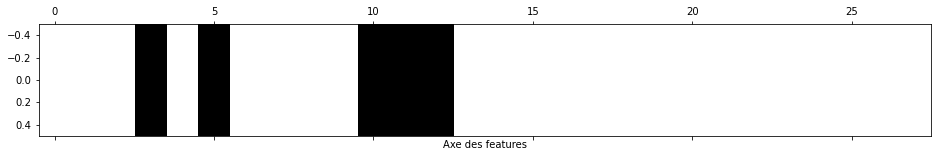

In [62]:
lasso = Lasso(alpha = 1)
model = SelectFromModel(estimator = lasso, threshold = 1e-10)
model.fit(X_train, y_train)

mask = model.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');
plt.show();


La difficulté de ces techniques est alors de choisir judicieusement le paramètre de régularisation.

- (e) Créer une grille de paramètres pour  α  variant entre 1 et 0.1.
- (f) Effectuer une grid search pour déterminer le meilleur paramètre  α  selon la métrique'neg_mean_squared_error' en utilisant le Lasso et leKFold précédemment créés.
- (g) Ajuster la grid search sur le jeu d'entrainement.
- (h) Afficher le meilleur paramètre retenu par la grid search.

In [63]:
alpha_grid = {'alpha':[1/i for i in range(1,10)]}
grid = GridSearchCV(estimator = lasso, param_grid = alpha_grid, cv=crossval, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'alpha': 0.1111111111111111}


Nous pouvons maintenant récupérer le jeu de features sélectionnées par le Lasso avec ces paramètres. Pour cela nous allons :

- (i) Utiliser l'attribut best_estimator_ de la grid search pour récupérer le Lasso entraîné avec les bons paramètres.
- (j) Créer un nouvel objet SelectFromModel en utilisant cet estimateur. L'argument prefit = True permet de spécifier que le modèle a déjà été ajusté sur le jeu de données (c'est le cas lorsqu'on récupère l'estimateur suite à une grid search).
- (k) Afficher la représentation graphique des features sélectionnés.

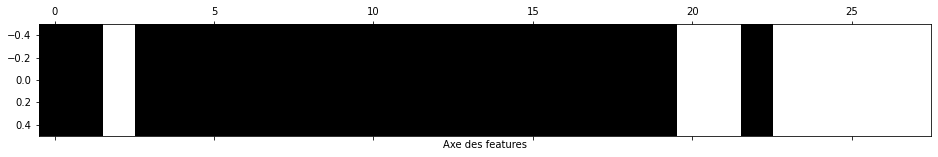

In [64]:
sel = SelectFromModel(estimator = grid.best_estimator_, threshold = 1e-10, prefit = True)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r', aspect='auto')
plt.xlabel('Axe des features');
plt.show();


## Conclusion 
Il est très compliqué de dresser une liste exhaustive des méthodes de Feature Selection et d'y associer leur cas d'usage typique.   

Cette partie de la Data science est considérée par beaucoup comme une discipline à part et est complexe à maitriser dans son ensemble.   

Gardez en tête qu'il est important d'utiliser vos connaissances métier lors de la phase de feature selection afin de choisir au mieux les méthodes à utiliser. N'hésitez pas à tester toutes sortes de méthodes sur vos datasets et à vous exercer régulièrement.

# 4 - Analyse en composantes principales (ACP) 
0. Contexte et objectif 
L'analyse en composantes principales (PCA pour Principal Component Analysis) est une méthode de réduction de dimension qui consiste à transformer des variables corrélées en nouvelles variables décorrélées les unes des autres.

Il s’agit de résumer l’information contenue dans un ensemble de données en un certain nombre de variables synthétiques, combinaisons linéaires des variables originelles : ce sont les Composantes Principales. Si l'on adopte un point de vue un peu plus mathématique, l'idée est de projeter l'ensemble des données sur l'hyperplan le plus proche des données. Les vecteurs directeurs de cet hyperplan sont les Composantes Principales.

Le choix du nombre de facteurs est important. L’enjeu est généralement de réduire de manière significative la dimension du jeu de données tout en conservant au maximum l'information véhiculée par les données. On parle de part de variance expliquée.

Dans les ensembles de données de grande dimension, il est très difficile de visualiser les données de manière efficace. Une façon d'y parvenir est de générer des diagrammes de dispersion bidimensionnels contenant tous les points de données pour chaque paire de caractéristiques possibles. Cependant, cette technique trouve rapidement ses limites lorsque la dimension du jeu de données augmente. Il peut alors être intéressant d'utiliser la PCA, en projetant les données sur 2 ou 3 axes, pour se faire une représentation visuelle du jeu de données. Cela permet parfois d'identifier des structures intéressantes et d'adapter au mieux le choix de son algorithme d'apprentissage par la suite.

L'exercice est composé de plusieurs questions. Vous êtes invités à les faire dans l'ordre ainsi qu'à faire attention à respecter le nom des variables.

1. Préparation et introduction 
- (a) à (f) charger les packages

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier

## - étude d'un texte tordu en S
Nous allons commencer cet exercice par un exemple simple afin de se familiariser avec le fonctionnement de la PCA. Nous allons générer un jeu de données bidimensionnel puis l'afficher. Nous ajouterons sur le graphique plusieurs axes, candidats pour être des Composantes Principales.

- (g) Exécuter le code dans la cellule suivante. Il générera le jeu de données et gèrera l'affichage.
- (h) D'après vous, quel est l'axe qui maximisera la part de variance expliquée une fois les données projetées dessus ?  
  
Il n'est pas nécessaire de se pencher sur le code fourni, il permet simplement de visualiser le mécanisme de la PCA. Nous aborderons la partie pratique dans quelques instants.

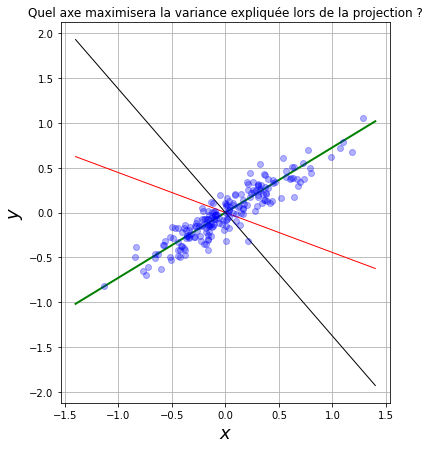

In [3]:
# Exéctuez cette cellule pour générer et afficher les données 2D

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(50)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

plt.figure(figsize=(13,7))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "g", linewidth=2)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "r", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k", linewidth=1)

plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.3)

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", fontsize=18)
plt.grid(True)
plt.title("Quel axe maximisera la variance expliquée lors de la projection ?")

plt.show();

## - projection des points sur 3 axes
Les données semblent se répartir le long de l'axe vert. C'est donc sur cet axe plutôt que sur le noir ou le rouge que nous devrions projeter nos données pour maximiser la variance expliquée. Nous allons le vérifier en affichant le résultat de la projection sur chacun des trois axes.

- (i) Exécuter le code dans la cellule suivante. Il affichera le résultat de la projection sur les trois axes.
- (j) Notre intuition est-elle confirmée ?

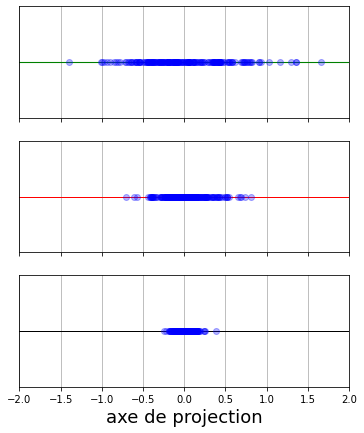

In [4]:
# Exécutez la cellule suivante pour projeter les données sur les 3 axes

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(13,7))

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "g", linewidth=1.1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "r", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k", linewidth=1)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("axe de projection", fontsize=18)
plt.grid(True)

plt.show()

Visuellement, on constate que c'est bien sur l'axe vert que les points se répartissent le mieux.  

C'est donc cet axe qui **maximise la variance** expliquée. La PCA fonctionne sur ce principe.   

Dans la réalité, on cherche plusieurs axes car le fait de projeter les données sur un seul axe ne permet pas d'avoir une part de variance expliquée satisfaisante.   

L'algorithme de la PCA fait en sorte que les axes soient orthogonaux entre eux. D'un point de vue statistique cela correspond à des composantes décorrélées entre elles, c'est à dire que l'information portée par le deuxième axe ne sera pas redondante avec celle portée par le premier axe, et ainsi de suite.

## 2. Application à un jeu de données de grande dimension 
Nous allons maintenant apprendre à utiliser scikit-learn pour faire une PCA sur des données réelles. Nous allons travailler sur le jeu de données Zalando MNIST. Il est constitué de 60.000 images de vêtements, de 28*28 pixels en noir et blanc. Chaque pixel est une feature et chaque image est une observation. La première colonne du jeu de données, label est la variable cible. Nous allons utiliser la luminosité des 784 pixels, évaluée entre 0 et 255 pour prédire la classe du vêtement. La dimension de ce jeu de données est donc 28 * 28 = 784. Voici un extrait des images contenues dans le jeu de données :  
Les classes sont numérotées de 0 à 9 comme suit :

Label	Description
- 0	T-shirt
- 1	Pantalon
- 2	Pulls
- 3	Robe
- 4	Manteau
- 5	Sandale
- 6	Chemise
- 7	Baskets
- 8	Sac
- 9	Bottines


- (a) Importer le jeu de données fashion_mnist_small.csv dans un dataframe nommé df.
- (b) Afficher les 5 premières lignes de df.

In [ ]:
""" mon process pour charger les données => trouver sur github """

In [10]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [12]:
#import mnist_reader  = data_set de 60.000 lignes   et ok 785 colonnes
X_train, y_train = load_mnist('data-fashion', kind='train')
X_test, y_test = load_mnist('data-fashion', kind='t10k')

In [16]:
X_train.shape

(60000, 784)

In [21]:
# je reconstitue data et target de datascientest mais sur 60.000 lignes et uniquement avec ce train_set qui est déjà assez gros comme ça !!
data = pd.DataFrame(X_train)
data.head()



,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
target = pd.DataFrame(y_train)
target.head()

,0
0,5
1,0
2,4
3,1
4,9


In [ ]:
""" leur process à eux que je ne lance pas """

In [ ]:
df = pd.read_csv("fashion_mnist_small.csv")
# => shape (10000, 785)
#(c) Stocker la colonne label dans une variable target.
#(d) Stocker toutes les features dans un nouveau df nommé data
target = df['label']          # (10000,)
data = df.drop('label',1)     # (10000, 784)

Nous allons afficher la première image du dataset. Les yeux les plus aguerris devraient y reconnaitre le maillot d'une célèbre équipe de football.

On utilisera la méthode iloc pour accéder à une ligne du dataframe, puis la méthode reshape pour transformer une ligne de données en une matrice de la bonne taille.

- (e) Extraire la première ligne du dataset dans une variable nommée img.
- (f) Afficher l'image correspondante en niveau de gris.

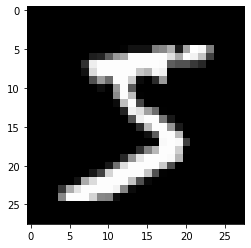

In [22]:
img = data.iloc[0]
img = np.array(img).reshape((28,28))
# On transforme la variable img en un objet numpy avant de reshape pour éviter un warning.
plt.imshow(img, cmap = 'gray');

# On aurait pu tout faire en une ligne comme suit (déconseillé car peu lisible !)
# plt.imshow(np.array(data.iloc[0]).reshape((28,28)), cmap = 'gray')

Nous allons maintenant appliquer la PCA sur nos données. En se limitant à deux composantes principales il est possible d'avoir une représentation visuelle de la répartition des données. Au-delà de 3 dimensions, le cerveau humain n'a pas de représentation efficace des espaces, ce qui rend les manipulations plus abstraites que dans des espaces de faible dimension.

La PCA est un algorithme non supervisé : c'est à dire que la valeur de la variable cible n'influence en rien le résultat de la PCA.

Avant d'effectuer une PCA il faut impérativement exclure la variable cible des données sur lesquelles l'algorithme est appliqué   
La méthode fit permet d'ajuster une PCA sur un jeu de données   

La méthode transform permet d'effectuer la transformation sur un jeu de données. Elle est forcément précédée de la méthode fit   
Les deux méthodes peuvent être combinées en appelant fit_transform.   

- (g) Créer pca une instance de PCA ne conservant que les deux premières composantes principales.
- (h) Appliquer la PCA sur les données.
- (i) Afficher les données projetées sur un graphe 2D en faisant varier la couleur selon la classe d'appartenance de chaque échantillon.
- (j) Calculer et afficher la part de variance expliquée.

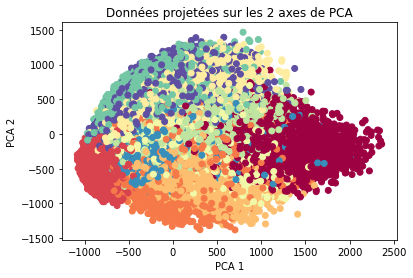

La part de variance expliquée est 0.17


In [23]:
pca = PCA(n_components = 2)
data_2D = pca.fit_transform(data)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(data_2D[:, 0], data_2D[:, 1], c = target, cmap=plt.cm.Spectral)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show();

print("La part de variance expliquée est", round(pca.explained_variance_ratio_.sum(),2))

Cette représentation visuelle n'est pas satisfaisante : plus de la moitié de l'information est perdue. Nous allons créer un nouvel objet PCA, **sans spécifier le nombre de composantes** cette fois-ci.  

Cela nous permettra d'étudier la façon dont le pourcentage de variance expliquée évolue avec le nombre de Composantes Principales retenues.

- (k) Créer une nouvelle instance de PCA sans spécifier le nombre de composantes.
- (l) Ajuster la PCA sur les données d'entrainement.
- (m) Afficher graphiquement la part de variance expliquée en fonction de l'index de la Composante Principale.
- (n) Tracer dans un nouveau graphe la somme cumulative de la variance expliquée.
- (o) Ajouter à ce second graphique une ligne horizontale à la hauteur y = 0.9.  

L'attribut **explained_variance_ratio** de l'object PCA contient un vecteur numpy de la taille du nombre de composantes de la PCA.  

Le i-ème élément de ce vecteur contient la part de variance expliquée par la ième composante principale.   

Ce vecteur peut être transformé pour avoir la somme cumulative de la part de variance expliquée en s'aidant de la méthode cumsum().

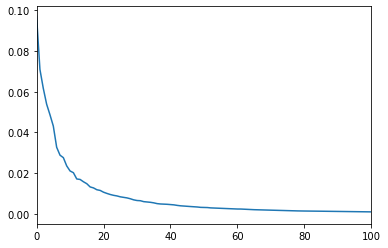

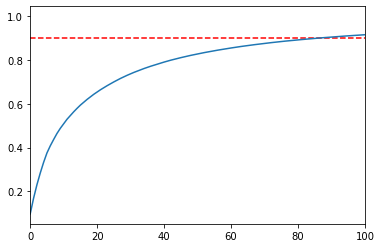

In [24]:
pca = PCA()  # prend toutes les features par défaut si n_components non renseigné
pca.fit(data)

plt.figure()
plt.xlim(0,100)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,100)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

On constate un **phénomène d'épaulement** sur ces graphes.   

Il est particulièrement visible sur le premier graphe, où les premières valeurs sont très élevées puis se stabilisent rapidement autour de 0,02.   
Cela nous **indique que la part de variance expliquée** est très importante sur les premières composantes principales puis décroit très rapidement.

On a pour habitude de considérer que **conserver 90% de la variance** d'un jeu de données est un seuil acceptable pour la PCA.   

Sur le deuxième graphe, on peut lire qu'il faut environ 80 Composantes Principales pour obtenir 90% de variance expliquée.

Plutôt que de spécifier à la méthode PCA le nombre de composantes que l'on veut conserver, on peut entrer un argument flottant compris entre 0 et 1 pour n_components. Il est alors interprété comme la part de variance expliquée à conserver.

- (p) Ajuster la PCA sur les données pour conserver 90% de la variance expliquée.
- (q) Afficher le nombre de composantes principales conservées.  

L'objet PCA a un **attribut ncomponents** qui contient le nombre de composantes retenues par l'algorithme.

In [25]:
pca = PCA(n_components = 0.9)
pca.fit(data)
print("Nombre de composantes retenues :", pca.n_components_)

Nombre de composantes retenues : 87


## 3. Utilisation du jeu de données réduit sur un problème d'apprentissage 

Nous allons utiliser un modèle d'apprentissage supervisé sur les données sans en réduire la dimension.  

Le résultat de ce modèle de classification nous servira de référence pour estimer les performances du modèle sur un jeu de données de dimension réduite.  

Nous allons utiliser le **classificateur Random Forest** implémenté dans scikit-learn.  

Nous allons maintenant utiliser deux jeux de données : l'un sera utilisé comme jeu d'entrainement et l'autre comme jeu de test. Cette séparation est déjà effectuée dans les fichiers csv fournis. La première étape est de préparer le jeu de données avec lequel nous allons travailler.

- (a) Importer le jeu de données 'fashion_mnist_test.csv' dans un DataFrame nommé X_test.
- (b) Importer le jeu de données 'fashion_mnist_train.csv' dans un DataFrame nommé X_train.
- (c) Stocker la colonne label du DataFrame test dans une variable nommée y_test.
- (d) Stocker la colonne label du DataFrame train dans une variable nommée y_train.
- (e) Supprimer la colonne label du DataFrame X_test.
- (f) Supprimer la colonne label du DataFrame X_train.  

Du fait de la taille importante de ces jeux de données, cette étape et la plupart des suivantes ont des temps d'éxecution plus importants.

In [ ]:
""" leur code impossible pour moi => ne pas lancer !!!   """

In [ ]:
X_test = pd.read_csv("fashion_mnist_test.csv")
X_train = pd.read_csv("fashion_mnist_train.csv")

y_test = X_test['label']
y_train = X_train['label']

X_test = X_test.drop('label',1)
X_train = X_train.drop('label',1)

In [ ]:
""" mon code solution """

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=5)

In [28]:
X_train.shape

(48000, 784)

- (g) Créer un classifieur Random Forest.
- (h) Entrainer le classifieur sur le jeu d'entrainement.
- (i) Estimer le score de prédiction de ce classifieur sur le jeu de test.  

La méthode score de l'objet RandomForestClassifier prend comme argument un jeu de test et les étiquettes correspondantes et retourne la proportion de bonnes prédictions effectuées par l'algorithme.

In [29]:
clf = RandomForestClassifier(n_jobs = -1)
# L'argument n_jobs vaut -1 par défaut. Il permet de forcer le processeur à utiliser toute sa puissance de calcul parallèle.
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

C:\Users\UserPC\AppData\Local\Temp\ipykernel_11992\2820165065.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.9668333333333333

In [30]:
type(y_train) # ils ont une série (60.000,) à la place de moi un dataframe (48.000, 1)

pandas.core.frame.DataFrame

In [31]:
y_train.shape  # voir par la suite s'il faut passer à (48.000, ) et idem pour y_test ?

(48000, 1)

Nous avons constaté précédemment que l'algorithme de la PCA nous permet de réduire la dimension d'un jeu de données sans en altérer la qualité.  

Maintenant, nous allons utiliser ce jeu de données réduit pour effectuer des prédictions concernant la classe des vêtements de nouvelles données.

Nous devons maintenant appliquer la PCA sur le jeu d'entrainement et le jeu de test.   

**Attention**, il faut appliquer la même transformation aux deux jeux de test, c'est-à-dire que les données d'entraînement et de test doivent être projetées sur le même nouveau plan et pas sur des plans différents.

En d'autres termes, il faut utiliser les méthodes fit et transform sur le jeu d'entraînement tandis qu'il faut utiliser uniquement la méthode transform sur jeu de test.

- (j) En conservant 90% de la variance, effectuer une PCA sur le jeu d'entrainement.
- (k) Appliquer la transformation au jeu de test.  

On notera que la méthode fit_transform permet d'appliquer les 2 méthodes fit et transform l'une après l'autre seule.

In [32]:
pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Notre jeu de données est préparé et sa dimension a été réduite. Nous pouvons passer à la phase d'apprentissage.

- (l) Créer un classifieur Random Forest.
- (m) Entraîner le classifieur sur le jeu d'entraînement.
- (n) Estimer le score de prédiction de ce classifieur sur le jeu de test.

In [33]:
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(X_train_pca, y_train)
clf.score(X_test_pca, y_test)

C:\Users\UserPC\AppData\Local\Temp\ipykernel_11992\3505978054.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_pca, y_train)


0.94975

Le score est très semblable à celui que nous avons obtenu précédemment alors que la dimension du jeu de données a presque été divisée par 10.   

Cela nous montre que la PCA a été efficace pour réduire la dimensionnalité tout en conservant l'information.   
C'est donc un algorithme très précieux et prisé des data scientist car il peut être appliqué en toutes circonstances ou presque et permet une accélération et parfois même une amélioration des performances des algorithmes d'apprentissage.

## . Comparaison avec l'algorithme LDA 
L'**analyse discriminante linéaire** (LDA, Linear Discriminant Analysis en anglais) fonctionne sur le même principe que la PCA :  
- la décomposition matricielle permet de projeter les données sur un hyperplan de l'espace original. 
- Cependant, là où la PCA peut s'appliquer sur toutes sortes de données, la LDA nécessite des données étiquetées. 
- L'idée derrière cet algorithme est de projeter les données de telle sorte que la variance au sein d'une classe soit la plus faible possible, tout en maximisant la variance entre les classes. 
- La LDA est donc un algorithme supervisé à l'inverse de la PCA qui est un algorithme non supervisé.

La LDA calcule ce qu'on appelle un **discriminant linéaire**, qui est en réalité une **frontière de décision entre les différentes classes**.  
Cette frontière est une combinaison linéaire des différentes features du jeu de données initial.

- (a) Créer un objet LDA.
- (b) Ajuster le modèle aux données d'entrainement puis appliquer la transformation aux données d'entrainement.
- (c) Appliquer cette même transformation aux données de test.
- (d) Afficher la taille du jeu d'entrainement après transformation.  

La méthode transform de l'objet LDA renvoie un array numpy dont la forme est accessible via son attribut shape.

In [34]:
lda = LDA()
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
X_train_lda.shape

C:\Users\UserPC\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(48000, 9)

Le nombre de features a été drastiquement réduit puisque nous n'en avons plus que 9, contre 784 au départ, alors que nous n'avons rien spécifié en ce sens lors de la création de l'objet LDA.   

En réalité, cela est dû à une limitation forte de la LDA : elle ne peut avoir plus que c-1 features, c étant le nombre de classes à prédire.

- (e) Créer un classifieur Random Forest.
- (f) Entraîner le classifieur sur le jeu d'entraînement.
- (g) Estimer le score de prédiction de ce classifieur sur le jeu de test.

In [35]:
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(X_train_lda, y_train)
clf.score(X_test_lda, y_test)

C:\Users\UserPC\AppData\Local\Temp\ipykernel_11992\1897310026.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_lda, y_train)


0.90725

Nous pouvons constater que la portion des bonnes prédictions est significativement similaire à celle obtenue avec une réduction de dimension via la PCA.  

En revanche, il est important de noter que la réduction de dimension est encore plus importante avec la LDA : ici le sous espace est de dimension 9 seulement !

Afin de parfaire notre compréhension de la LDA, nous allons effectuer une représentation graphique comparée des données projetées par la LDA et des données projetées par la PCA.

- (h) Afficher le premier axe de la PCA en fonction du second.
- (i) Afficher le premier axe de la LDA en fonction du second.

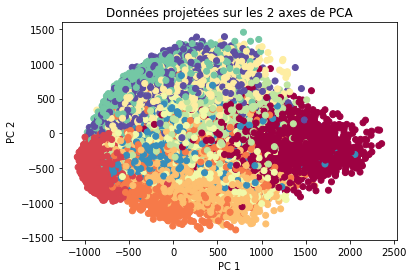

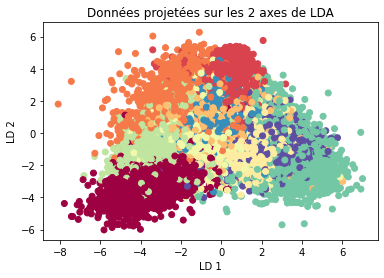

In [36]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1],  c = y_train, cmap=plt.cm.Spectral)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show();

fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c = y_train, cmap=plt.cm.Spectral)

ax.set_xlabel('LD 1')
ax.set_ylabel('LD 2')

ax.set_title("Données projetées sur les 2 axes de LDA")
plt.show();

Nous pouvons constater que les deux algorithmes fournissent une partition très différente des données dans l'espace.   

La PCA occupe un maximum d'espace disponible en étalant les données sans tenir compte de leur étiquette : 
- il est quasi impossible de distinguer aisément des groupes de points d'une même couleur sur le graphe. 
- A l'inverse, la LDA groupe les éléments de même couleur (et donc de même classe) ensemble. 
- Si la partie supérieure gauche est moins lisible, on distingue nettement plusieurs groupes dans le reste du graphe.

Nous avons vu dans la deuxième partie de ce tutoriel que la LDA, en tant qu'algorithme de réduction de dimension, peut donner d'excellents résultats. 
- En revanche, elle n'est adaptée que dans le cas de problèmes de classification supervisée avec des features continues où le nombre de classes à prédire est suffisamment important. - - C'est donc un algorithme nettement moins polyvalent que la PCA.

Il est à noter que la LDA peut également servir en tant qu'algorithme de classification mais que nous n'aborderons pas cette partie dans ce tutoriel. Vous trouverez des informations à ce sujet sur la fiche technique correspondante.

# 5 - Manifold learning 
## 0. Contexte et objectif
Bien que la PCA soit la méthode la plus commune pour la réduction de dimension, elle a pour désavantage de n'identifier que les corrélations linéaires entre les variables.  
Nous allons aborder dans cet exercice les méthodes qui permettent d'identifier des relations non linéaires entre les variables, et de "dérouler" des jeux de données à priori complexes.

Prenons un instant pour nous imaginer une feuille de papier dans un espace en 3 dimensions. La tourner, ou la faire basculer ne changera rien aux relations entre les points de cette feuille de papier, c'est toujours un objet en 2D dans un espace en 3D. En revanche, si nous décidons d'en faire une boulette, nous aurons une base 2D, mais la structure de la boulette est bel et bien tri-dimensionnelle. Les algorithmes de manifold learning ont pour objectif d'identifier les relations entre les points de la boulette pour reconstituer la nature fondamentalement bi-dimensionnelle de la figure tri-dimensionnelle qu'est la boulette. Cette base est appelée le manifold en anglais.

Alors que la PCA est un algorithme très puissant pour identifier les relations linéaires, nous allons aborder des approches plus qualitatives que quantitatives dans cet exercice. L'objectif est bien souvent de visualiser les données pour mieux choisir les méthodes à appliquer sur les données. Le manifold learning fait rarement partie d'un pipeline d'apprentissage automatique mais doit faire partie de l'arsenal d'un data scientist aguerri. Il est à noter que la PCA peut être combinée à l'astuce du noyau pour réaliser des réductions de dimension non linéaires, nous n'aborderons pas ce point dans cet exercice.

L'exercice est composé de plusieurs questions. Vous êtes invités à les faire dans l'ordre ainsi qu'à faire attention à respecter le nom des variables.

## 1. Préparation et introduction 
- (a) Exécuter la cellule suivante pour importer toutes les fonctions nécessaires pour réaliser cet exercice.

In [69]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
from mpl_toolkits import mplot3d

import numpy as np
import pandas as pd

from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE
from sklearn.decomposition import PCA

%matplotlib inline

Nous allons mettre en application le problème de la feuille de papier dont nous avons parlé en introduction. Le jeu de données que nous allons utiliser est un nuage de points représentant un texte simple ("Data").   

Nous allons ensuite appliquer à ces points une transformation non linéaire dans un espace tri-dimensionnel. Enfin, nous verrons par quels moyens il est possible de retrouver le texte initial.

Pour simplifier le code de cette première partie nous n'allons pas utiliser un DataFrame pandas mais un array numpy pour stocker le jeu de données. numpy dispose d'une fonction genfromtxt qui s'utilise comme la fonction read_csv de pandas.

- (b) Utiliser numpy pour charger le fichier 'Data_text.csv' dans un array nommé X.
- (c) Afficher les données sur un graphe.

In [70]:
df = pd.read_csv('Data_text.csv', sep=';')
df.shape

(275, 2)

In [71]:
df.head()

,0.599726,0.551087
0,0.601543,0.394790
1,0.601693,0.803500
2,0.602760,0.845518
3,0.602959,0.243764
4,0.603079,0.826334


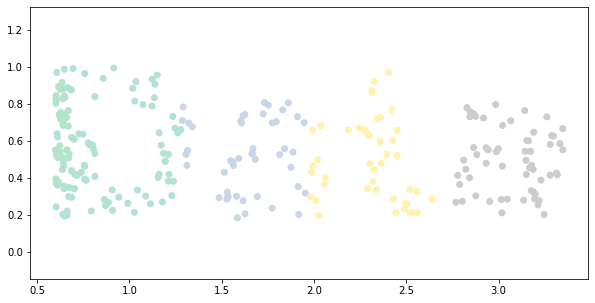

In [72]:
X = np.genfromtxt('Data_text.csv', delimiter=';')
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('Pastel2', 4))
plt.figure(figsize=(10,5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

Nous allons maintenant définir la fonction qui va transformer notre jeu de données.  

Le texte va se courber en suivant la forme d'un S, rendant toute forme de projection linéaire inefficace pour retrouver le texte original.

- (d) Appliquer la fonction make_data_s_curve au jeu de données et stocker le résultat dans une variable nommée XS.
- (e) Afficher le texte plié sur un graphe tri-dimensionnel.

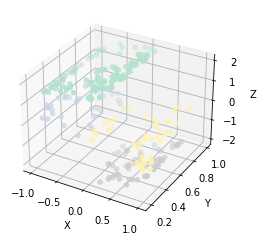

In [73]:
def make_data_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

# Insérez votre code ici
XS = make_data_s_curve(X)
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

Dorénavant, notre objectif est de trouver une méthode qui permet de retrouver le texte "Data" en aplatissant la forme de S.   

Nous cherchons donc à réduire la dimension de notre dataset, de 3 dimensions à 2 dimensions. Pour faire cela, la PCA chercherait la surface la plus à même de représenter la variance des données, mais dans notre cas cette surface n'existe pas, ou en tous cas ne permettrait pas de visualiser la structure des données.

Une des techniques de manifold learning les plus classiques est la MDS, pour MultiDimensionnal Scaling. Le principe est de chercher un espace de dimension inférieure à l'espace originel, qui maintienne au mieux les distances entre les points dans l'espace d'origine.

- (f) Ajuster le modèle fourni sur les données et transformer les données.
- (g) Afficher les données dans l'espace réduit par la MDS sur un graphe 2D.

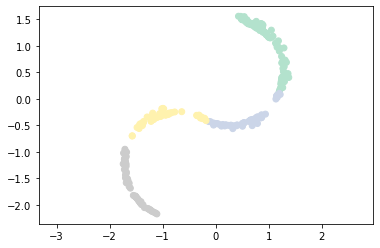

In [74]:
model = MDS(n_components=2, random_state=1)
X_MDS = model.fit_transform(XS)
plt.scatter(X_MDS[:, 0], X_MDS[:, 1], **colorize)
plt.axis('equal');

Ici, la MDS ne fait guère mieux qu'une projection sur l'axe X, elle ne parvient pas à dérouler le jeu de données.   
On a perdu toute l'information qui était le texte et on ne récupère que la forme de la transformation : 
- le S. On obtient des informations sur la structure de la donnée mais pas sur la façon dont les points se répartissent dans cette structure.

Le problème ici est que la MDS essaie de préserver les distances entre tous les points aussi éloignés soient ils les uns des autres.  
Il est alors impossible de dérouler le jeu de données tout en conservant les distances entre les points de deux couches superposées.   
Une parade à ce problème serait alors de ne considérer, pour un point, qu'un certain nombre de voisins avec lesquels il faut préserver les distances.  
- C'est le principe de la **LLE, pour Locally Linear Embedding**. Nous pouvons visualiser la différence entre les deux algorithmes sur l'image suivante, où chaque trait noir représente une distance à réserver par l'algorithme :

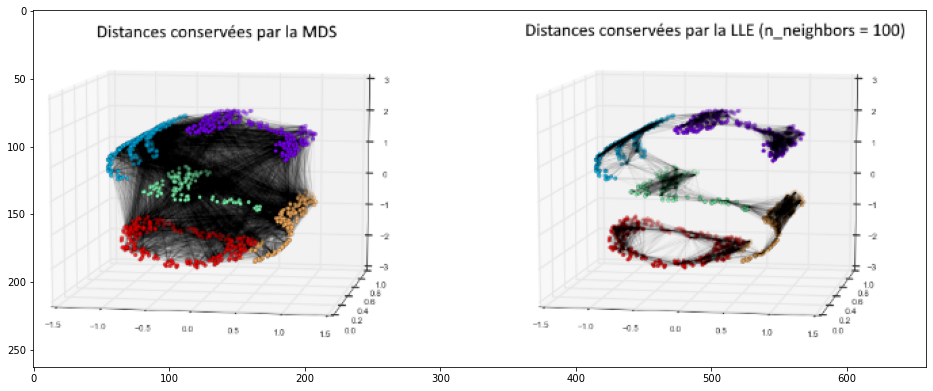

In [75]:
from matplotlib import image
# pour afficher n'importe quelle image du dossier de W
img = image.imread('MDS-LLE red-dim.png')
plt.figure(figsize=(16, 12))
plt.imshow(img)

Nous allons maintenant utiliser la LLE sur notre jeu de données transformé et comparer les résultats.

- (h) Instancier un objet de la classe LocallyLinearEmbedding qui prendra en compte 40 voisins pour réduire le jeu de données à 2 dimensions.
- (i) Ajuster le modèle sur les données et transformer les données.
- (j) Afficher les données dans l'espace réduit par la LLE sur un graphe 2D.    

Le paramètre "method" de la LLE permet de choisir quelle variante de la LLE sera utilisée par sklearn. Dans notre cas, n_neighbors > n_components. La méthode à préférer est la méthode 'modified'.  

Au vu de la faible taille du jeu de données, on peut ici utiliser eigen_solver = 'dense'. Pour des problèmes de plus grande dimension, on préfèrera la version 'arpack', dont l'initialisation aléatoire permet une complexité nettement inférieure.

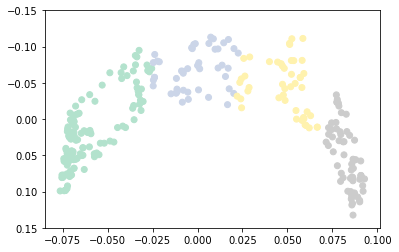

In [76]:
model = LocallyLinearEmbedding(n_neighbors=40, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);


Cette fois ci le dataset a été déroulé. Le message a subi une transformation puisqu'il est en symétrique par rapport à sa version originale mais l'information est lisible et la structure originale aisément identifiable.

L'algorithme LLE nous a permis de dérouler la structure du S autour de laquelle les données étaient enroulées pour voir plus clair dans la structure des données. Le même principe est appliqué dans le monde réel.

## 2. Application à un jeu de données de grande dimension 
Nous allons reprendre le jeu de données Zalando MNIST que nous avons utilisé pour l'exercice précédent. Pour rappel, il est constitué de 60.000 images de vêtements, de 28*28 pixels en noir et blanc. 

Chaque pixel est une feature et chaque image est une observation. La première colonne du jeu de données, label est la variable cible. Nous allons appliquer différentes techniques de manifold learning sur ce jeu de données et comparer les résultats.


- (a) Importer le jeu de données 'fashion_mnist_small.csv' dans un DataFrame nommé df.
- (b) Afficher les 5 premières lignes de df.


In [77]:
""" mon process pour charger les données => trouvé sur github """

' mon process pour charger les données => trouvé sur github '

In [78]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [79]:
#import mnist_reader  = data_set de 60.000 lignes   et ok 785 colonnes
X_train, y_train = load_mnist('data-fashion', kind='train')
X_test, y_test = load_mnist('data-fashion', kind='t10k')

In [80]:
X_train.shape

(60000, 784)

In [81]:
# je reconstitue data et target de datascientest mais sur 60.000 lignes et uniquement avec ce train_set qui est déjà assez gros comme ça !!
data = pd.DataFrame(X_train)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
target = pd.DataFrame(y_train)
target.head()

,0
0,5
1,0
2,4
3,1
4,9


Nous allons appliquer la LLE modifiée sur notre jeu de données réelles et observer comment l'algorithme construit un espace de dimension 2 depuis un espace de dimension 784. La réduction de dimension est ici particulièrement forte pour permettre la visualisation. Il est possible que 2 dimensions ne soit pas suffisantes pour isoler un manifold au sein de nos données.

- (e) Ajuster l'algorithme sur les données et stocker les données dans l'espace de dimension réduite dans une nouvelle variable.  

Tous les algorithmes de manifold learning sont non supervisés : la table target nous sera inutile lors de l'entrainement des modèles.

Les algorithmes de manifold learning ont souvent des complexités importantes : il est normal que le temps d'exécution dépasse la minute sur certaines cellules.

In [ ]:
lle = LocallyLinearEmbedding(n_neighbors=20, n_components=2, method='modified', random_state = 42)  # eux 50 voisins mais calculs trop long !
# Insérez votre code ici
dataLLE = lle.fit_transform(data)

- (f) Afficher les données projetées sur un graphe 2D en faisant varier la couleur selon la classe d'appartenance de chaque échantillon.

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dataLLE[:, 0], dataLLE[:, 1],  c = target, cmap=plt.cm.Spectral, alpha = .7, s = 4)

#ax.set_xlabel('LL 1')
#ax.set_ylabel('LL 2')

ax.set_title("Manifold 2D identifié par la LLE")
plt.show();


Cette visualisation ne semble pas nous aider, en effet les points sont particulièrement groupés au milieu de l'espace et on ne distingue pas clairement toutes les classes indépendamment. La structure que nous observons est caractéristique d'une réduction de dimension effectuée par l'algorithme LLE.

Il est possible sur ce graphe d'identifier certains groupes de points d'une même classe mais ne permet pas de séparer toutes les classes. Cependant, ce n'est pas le but de cet algorithme qui n'est **pas un algorithme de clustering**.

Même si nous ne pouvons pas facilement distinguer les classes sur cette représentation, une autre possibilité est d'afficher les images correspondantes aux points sur le graphique. Il sera alors possible d'identifier quelles caractéristiques de l'image influencent son placement sur le graphe. Cette méthode est en fait une alternative qualitative à l'analyse des composantes de la PCA. Pour cela, nous allons définir une fonction plot_components qui effectuera pour nous cette représentation graphique complexe. C'est une visualisation qui est souvent efficace lorsque l'on utilise les algorithmes de manifold learning

- (g) Exécuter la cellule de code qui définit la fonction plot_components.

In [ ]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

La fonction **plot_components** permet d'effectuer la visualisation dont nous avons besoin. Vous pouvez tout à fait vous plonger dans la lecture du code, qui vous est fourni par souci d'efficacité, si vous avez suivi la formation en Dataviz.  

- (h) Utiliser la fonction plot_components pour afficher les objets du manifold identifié par la LLE sur un graphe 2D.  

Le paramètre thumb_frac de la fonction plot_components permet de choisir le nombre d'images à afficher sur le graphique.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data = dataLLE, model = lle, images=data.values.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, prefit = True)

L'interprétation de ce graphe est purement qualitative.   

Il semblerait que la largeur de l'objet détermine son placement sur l'axe horizontal et la hauteur son placement sur l'axe vertical.  
Cependant, il existe autant de lectures possibles que de Data Scientists dans le monde, et il n'y a pas de mauvaise réponse à la question de savoir quels sont les facteurs qui influencent le placement des items sur ce graphe.  

Ce graphe va nous permettre d'avoir des intuitions sur ce qui fonde les différences entre les images de notre dataset, sur quelles features sont importantes.

On pourrait imaginer ajouter à notre dataset des données sur la largeur et la hauteur des vêtements photographiés. Cela serait une piste d'amélioration pour le problème de classification. Nous n'irons pas au bout de cette intuition car cela serait trop long pour entrer dans le cadre de cette formation, mais l'exercice peut être intéressant à réaliser.

- Nous allons maintenant utiliser l'**algorithme Isomap**.   

Habituellement, cet algorithme est plus efficace sur les données de haute dimension issues du monde réel alors que LLE est particulièrement efficace sur des transformations régulières et peu bruitées comme nous l'avons vu dans le premier exemple.

Le principe d'Isomap est sensiblement le même que celui de la LLE : le graphe de plus court chemin entre un point et ses k plus proche voisins est utilisé pour projeter les données dans un espace de plus faible dimension.

Les principaux paramètres de la fonction Isomap sont n_neighbors et n_components.

- Les algorithmes comme **LLE et Isomap** reposent sur un hyperparamètre qui est le nombre de voisins à prendre en compte. Cet hyperparamètre peut faire fortement varier les résultats, sans que l'on dispose pour autant d'une métrique permettant de déterminer quelle valeur donne les meilleurs résultats.  

Il faut donc tester plusieurs valeurs de k avant de rejeter un modèle de manifold learning sur un dataset donné

- (i) Créer un objet isomap qui prend en compte les 50 plus proches voisins de chaque point pour réduire le jeu de données à 2 dimensions.
- (j) Utiliser cet objet pour créer dataISO qui contient les données projetées sur deux composantes.

In [ ]:
isomap = Isomap(n_neighbors=50, n_components=2)
dataISO = isomap.fit_transform(data)


Cette étape a dû prendre un certain temps. Nous allons maintenant pouvoir visualiser les résultats.

- (k) Afficher les données projetées sur un graphe 2D en faisant varier la couleur selon la classe d'appartenance de chaque échantillon.

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dataISO[:, 0], dataISO[:, 1],  c = target, cmap=plt.cm.Spectral, alpha = .7, s = 4)

ax.set_title("Données projetées sur les 2 composantes de Isomap")
plt.show();

Nous l'avons déjà souligné, il n'existe pas de métrique pour mesurer les performances d'un algorithme de manifold learning par rapport à l'autre. Il ne serait ici pas pertinent de mesurer les performances d'un algorithme de classification sur les données projetées car l'objet de cette réduction de dimension n'est pas d'ajuster des algorithmes dans la foulée mais seulement de visualiser les données dans différents espaces.

Comme avec la LLE, l'algorithme Isomap nous permet de capturer certaines des relations entre les variables mais la densité de points nous empêche de réaliser une analyse fine de cette représentation graphique.

L'**algorithme t-SNE** sert le même but que les deux précédents en utilisant une approche tout à fait différente. t-SNE signifie t-distributed Stochastic Neighborhood Emebedding. L'algorithme t-SNE se base sur une interprétation probabiliste des proximités. Une distribution de probabilité est définie sur les paires de points de l'espace d'origine de telle sorte que des points proches l'un de l'autre ont une forte probabilité d'être choisis tandis que des points éloignés ont une faible probabilité d'être sélectionnés. Une distribution de probabilité est également définie de la même manière pour l'espace de faible dimension. L'algorithme t-SNE consiste à faire concorder les deux densités de probabilité, en minimisant un critère mathématique entre les deux distributions par rapport à l'emplacement des points sur la carte.

   Nous avons ici un jeu de données où toutes les features sont de même nature. Dans le cas contraire, il est indispensable d'avoir une étape de pre-processing pour standardiser les features. Les algorithmes de manifold learning se reposant sur des algorithmes de plus proche voisin, sans standardisation les résultats seraient absurdes. Cet avertissement est valable pour tous les algorithmes présentés dans cet exercice.  
   
- (l) Créer un objet tsne qui va conserver 2 composantes et utiliser la **méthode de Barnes Hut**.
- (m) Ajuster l'algorithme sur les données et stocker les données dans l'espace de dimension réduite dans une nouvelle variable.

In [ ]:
tsne = TSNE(n_components=2, method = 'barnes_hut')
dataTSNE = tsne.fit_transform(data)

Vous l'avez constaté, cette méthode est particulièrement longue à s'ajuster sur les données. La méthode 'barnes_hut' est pourtant la plus rapide, la méthode 'exact' est nettement plus coûteuse sans apporter des performances bien supérieures.  

L'algorithme t-SNE a plusieurs avantages par rapport aux méthodes que nous avons précédemment citées. Il a notamment moins tendance à grouper les points au centre de l'espace de faible dimension, et il peut détecter plusieurs structures distinctes au sein d'un espace de haute dimension, comme c'est le cas dans notre dataset Zalando MNIST.

- (n) Afficher les données projetées sur un graphe 2D en faisant varier la couleur selon la classe d'appartenance de chaque échantillon.

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(dataTSNE[:, 0], dataTSNE[:, 1],  c = target, cmap=plt.cm.Spectral, alpha = .7, s = 4)

ax.set_title("Données projetées sur les 2 axes de Tsne")
plt.show();


On constate sur cette visualisation que l'algorithme t-SNE fonctionne beaucoup mieux que les algorithmes Isomap ou LLE sur des données hautement partitionnées comme c'est le cas ici.  
En séparant les classes de cette manière, il est possible d'interpréter la distance entre les clusters comme une sorte de mesure de dissimilarité : les clusters les plus proches représentent des groupes de points semblables.   

On pourrait croire, au premier abord, que l'algorithme a simplement fonctionné comme un algorithme de clustering. En regardant en détail ce qui s'est passé pour une classe donnée nous pourrons constater qu'en réalité, en plus de séparer les classes, l'algorithme capture ce qui fait la variance au sein d'une classe et répartit les points d'un cluster en fonction.

Ne pas réussir à visualiser des clusters ou des relations entre les données suite à l'application d'un algorithme de manifold learning ne veut pas nécessairement dire que l'algorithme ou les hyperparamètres ne sont pas les bons. Cela peut aussi indiquer que la réduction de dimension est trop importante pour capturer la structure fondamentale des données.

Nous allons maintenant analyser comment t-SNE distribue les objets d'une classe, et comment cette analyse peut nous permettre de comprendre la structure interne des classes du jeu de données.

- (o) Créer un nouveau dataset avec seulement les manteaux.
- (p) Utiliser la fonction plot_components sur ce nouveau jeu de données avec le modèle t-SNE.

In [ ]:
data_mant = data[target == 4]
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data_mant, tsne, images=data_mant.values.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.1, cmap='gray_r')

On peut voir sur ce graphe que les manteaux les plus sombres sont au sommet tandis que les plus clairs sont plutôt vers le bas.   

De plus, il semblerait que ce soit la longueur du manteau qui soit un paramètre important. Les manteaux courts semblent être plutôt sur la droite tandis que les manteaux longs se retrouvent davantage sur la gauche du graphe. L'initialisation via la méthode de Barnes Hut peut néanmoins conduire à des résultats différents d'une itération à l'autre.  

Il est donc possible que vos résultats soient différents de ceux qui ont permis la rédaction de l'exercice.

Vous l'aurez compris, il est nécessaire de faire plusieurs essais sur un dataset afin de saisir un maximum de structures internes dans les données.   

Même si le manifold learning ne permet pas de classifier les données, son objectif est de nous inspirer pour la phase de pre-processing d'un pipeline d'apprentissage. Pour tirer le meilleur de ces d'algorithmes, il n'y a pas de recette miracle ou de protocole à appliquer à la lettre, il est nécessaire de s'exercer régulièrement pour avoir l'oeil.

Cet exercice conclut la formation à la réduction de dimension qui a présenté différentes méthodes pour réduire la dimension d'un dataset.